# Оптимизация производственных расходов металлургического комбината «Стальная птица»

## ЦЕЛЬ ПРОЕКТА

Построить модель, которая будет предсказывать температуру сплава.

Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

Ваша задача — построить модель, которая будет её предсказывать.

Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

1. data_arc_new.csv — данные об электродах;

2. data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

3. data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

4. data_gas_new.csv — данные о продувке сплава газом;

5. data_temp_new.csv — результаты измерения температуры;

6. data_wire_new.csv — данные о проволочных материалах (объём);

7. data_wire_time_new.csv — данные о проволочных материалах (время).


1. Файл data_arc_new.csv:

* key — номер партии;
* Начало нагрева дугой — время начала нагрева;
* Конец нагрева дугой — время окончания нагрева;
* Активная мощность — значение активной мощности;
* Реактивная мощность — значение реактивной мощности.

2. Файл data_bulk_new.csv:
* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

3. Файл data_bulk_time_new.csv:
* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

4. Файл data_gas_new.csv:
* key — номер партии;
* Газ 1 — объём подаваемого газа.

5. Файл data_temp_new.csv:
* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

6. Файл data_wire_new.csv:
* key — номер партии;
* Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

7. Файл data_wire_time_new.csv:
* key — номер партии;
* Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка данных

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
paths = {
    "data_arc": r'C:\Users\dinos\Downloads\data_arc_new.csv',
    "data_arc_alt": '/datasets/data_arc_new.csv',
    "data_bulk": r'C:\Users\dinos\Downloads\data_bulk_new.csv',
    "data_bulk_alt": '/datasets/data_bulk_new.csv',
    "data_bulk_time": r'C:\Users\dinos\Downloads\data_bulk_time_new.csv',
    "data_bulk_time_alt": '/datasets/data_bulk_time_new.csv',
    "data_gas": r'C:\Users\dinos\Downloads\data_gas_new.csv',
    "data_gas_alt": '/datasets/data_gas_new.csv',
    "data_temp": r'C:\Users\dinos\Downloads\data_temp_new.csv',
    "data_temp_alt": '/datasets/data_temp_new.csv',
    "data_wire": r'C:\Users\dinos\Downloads\data_wire_new.csv',
    "data_wire_alt": '/datasets/data_wire_new.csv',
    "data_wire_time": r'C:\Users\dinos\Downloads\data_wire_time_new.csv',
    "data_wire_time_alt": '/datasets/data_wire_time_new.csv'
}

In [3]:
def load_data(primary_path, alt_path, **kwargs):
    if os.path.exists(primary_path):
        return pd.read_csv(primary_path, **kwargs)
    elif os.path.exists(alt_path):
        return pd.read_csv(alt_path, **kwargs)
    else:
        print(f"Файл не найден: {primary_path} или {alt_path}")
        return None

data_arc = load_data(paths["data_arc"], paths["data_arc_alt"], sep=',', parse_dates=[1, 2])
data_bulk = load_data(paths["data_bulk"], paths["data_bulk_alt"])
data_bulk_time = load_data(paths["data_bulk_time"], paths["data_bulk_time_alt"])
data_gas = load_data(paths["data_gas"], paths["data_gas_alt"])
data_temp = load_data(paths["data_temp"], paths["data_temp_alt"], parse_dates=[1])
data_wire = load_data(paths["data_wire"], paths["data_wire_alt"])
data_wire_time = load_data(paths["data_wire_time"], paths["data_wire_time_alt"])

pd.set_option('display.max_columns', None)

In [4]:
def info(df):
    display(df.head(5))
    display(df.info()) 
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('Количество пропусков:')
    print(df.isna().sum())

In [5]:
info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

Количество дубликатов: 0
Количество пропусков:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [6]:
info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество дубликатов: 0
Количество пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [7]:
info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Количество дубликатов: 0
Количество пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [8]:
info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Количество дубликатов: 0
Количество пропусков:
key      0
Газ 1    0
dtype: int64


In [9]:
info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

Количество дубликатов: 0
Количество пропусков:
key                0
Время замера       0
Температура     3427
dtype: int64


In [10]:
info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество дубликатов: 0
Количество пропусков:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [11]:
info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Количество дубликатов: 0
Количество пропусков:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Вывод
* Наименование столбцов написаны на разных языках, приведем все к латинице
* Столбцы с датой привети к временному типу данных
* Явные дубликаты остуствуют
* Имеются пропуски в данных

## Исследовательский анализ и предобработка данных

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def hist_box(df, col, bins=50, color='green'):

    sns.set(style="whitegrid", font_scale=1.1)

    fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

    sns.histplot(df[col], ax=axs[0], color=color, bins=bins)
    axs[0].set_title(f'Распределение {col}', fontsize=20)
    axs[0].set_xlabel(col, fontsize=14)
    axs[0].set_ylabel('Частота', fontsize=14)

    sns.boxplot(x=df[col], ax=axs[1], color=color)
    axs[1].set_title(f'Ящик с усами {col}', fontsize=20)
    axs[1].set_xlabel(col, fontsize=14)

    print("Статистическое описание столбца:")
    print(df[col].describe())

    plt.tight_layout()
    plt.show()

In [13]:
data_arc.columns = ['key', 'start_heat','end_heat', 'active_power', 'reactive_power']
data_arc.columns

Index(['key', 'start_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

Статистическое описание столбца:
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64


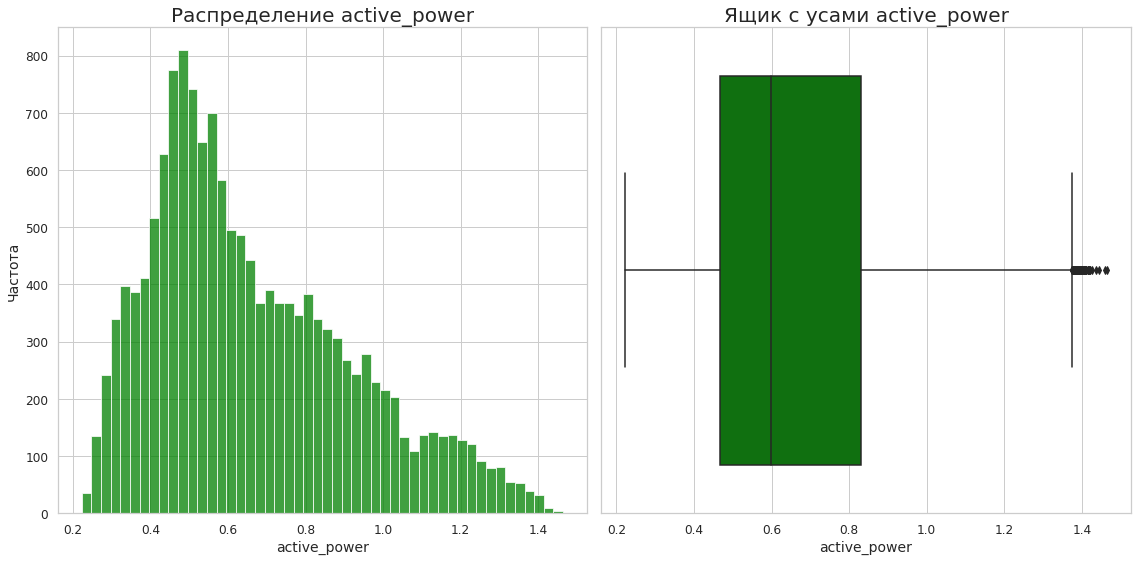

In [14]:
hist_box(data_arc,'active_power')

Статистическое описание столбца:
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


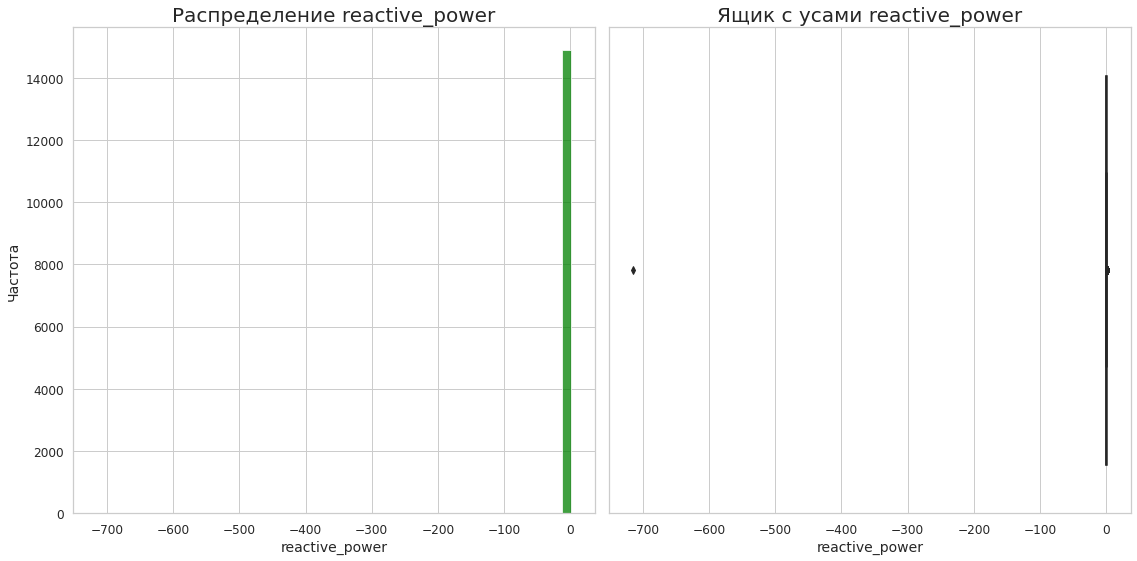

In [15]:
hist_box(data_arc,'reactive_power')

In [16]:
data_arc = data_arc.query('reactive_power > 0')

Статистическое описание столбца:
count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: reactive_power, dtype: float64


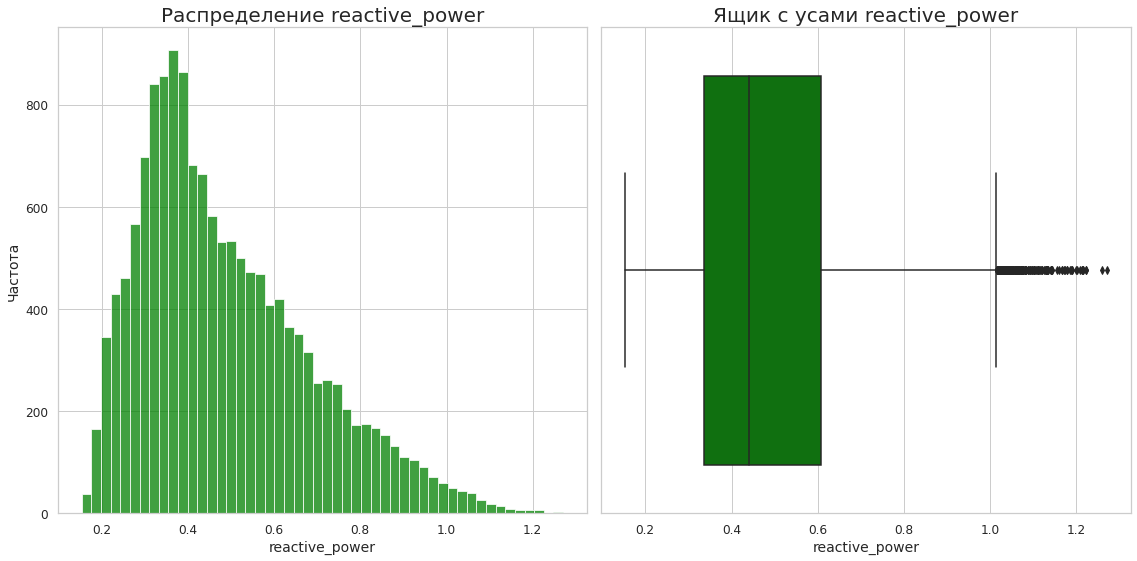

In [17]:
hist_box(data_arc,'reactive_power')

Вычислим полную мощность:
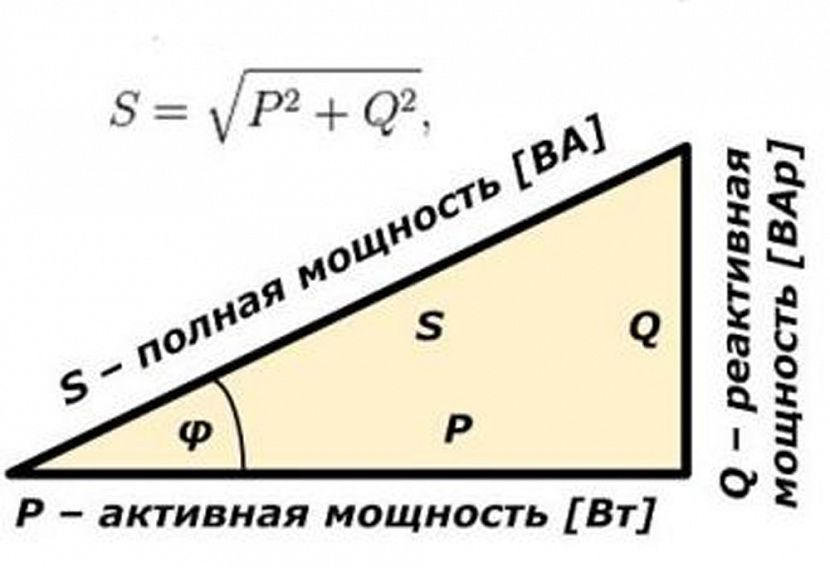

In [18]:
data_arc['real_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

Также посчитаем время нагрева:

In [19]:
data_arc['heat_time'] = data_arc['end_heat'] - data_arc['start_heat']
data_arc['heat_time'] = data_arc['heat_time'].dt.seconds

In [20]:
data_arc.head()

,key,start_heat,end_heat,active_power,reactive_power,real_power,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148


Теперь вычислим затраты электроэнергии:

In [21]:
data_arc['electricity_costs'] = data_arc['real_power']*data_arc['heat_time']

In [22]:
data_arc = data_arc.groupby(by = 'key').sum()
data_arc.head()

,active_power,reactive_power,real_power,heat_time,electricity_costs
key,,,,,
1,3.036730,2.142821,3.718736,1098,770.282114
2,2.139408,1.453357,2.588349,811,481.760005
3,4.063641,2.937457,5.019223,655,722.837668
4,2.706489,2.056992,3.400038,741,683.455597
5,2.252950,1.687991,2.816980,869,512.169934


Статистическое описание столбца:
count    3214.000000
mean        3.810779
std         1.502804
min         0.331897
25%         2.775306
50%         3.694219
75%         4.696915
max        15.288271
Name: real_power, dtype: float64


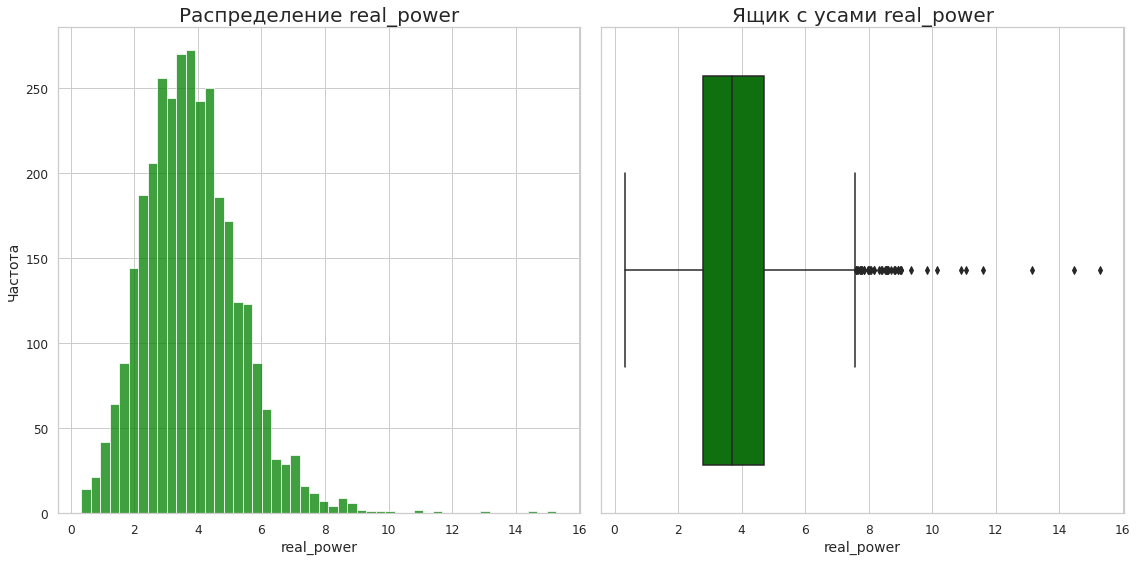

In [23]:
hist_box(data_arc,'real_power')

Статистическое описание столбца:
count    3214.000000
mean      794.545115
std       332.491076
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: heat_time, dtype: float64


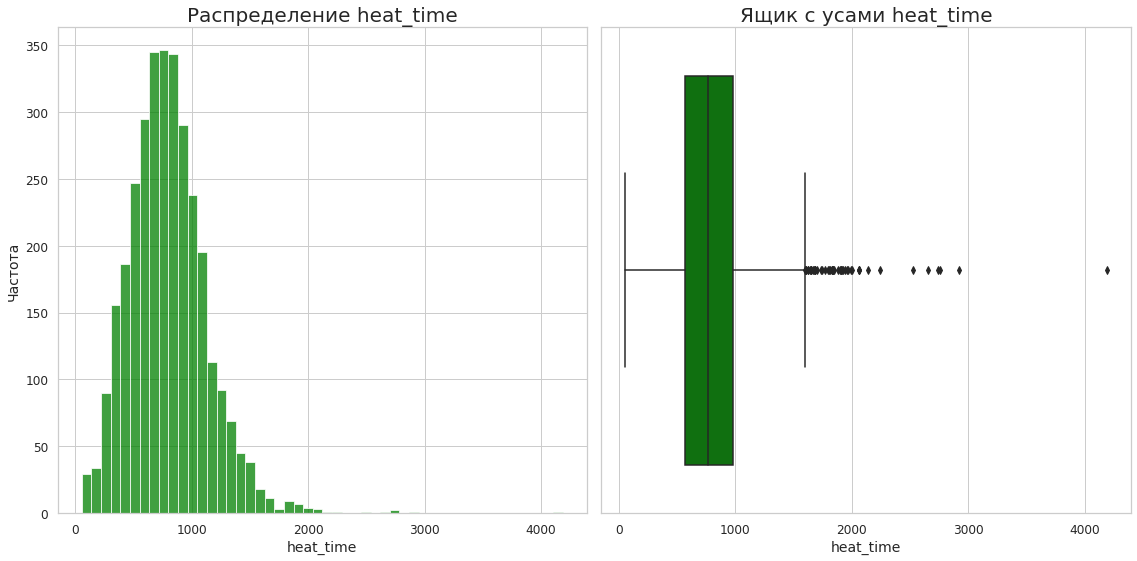

In [24]:
hist_box(data_arc,'heat_time')

Статистическое описание столбца:
count    3214.000000
mean      655.569107
std       308.976732
min        33.430208
25%       444.626580
50%       620.101427
75%       827.671845
max      4546.405812
Name: electricity_costs, dtype: float64


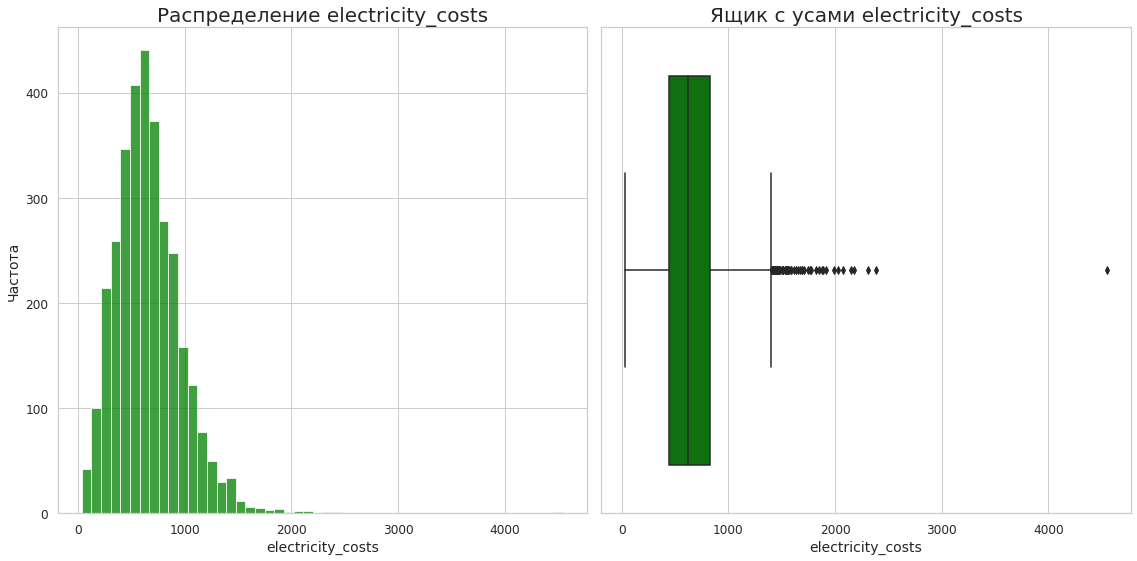

In [25]:
hist_box(data_arc,'electricity_costs')

In [26]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       3214 non-null   float64
 1   reactive_power     3214 non-null   float64
 2   real_power         3214 non-null   float64
 3   heat_time          3214 non-null   int64  
 4   electricity_costs  3214 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


После создания новых признаков и группировки мы видим, что распределение новых признаков имеют определенное количество выбросов. Пока что оставим их без изменений.

### Анализ data_bulk_new

В data_bulk_new изменим название столбцов и приведём в надлежащий вид

In [27]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [28]:
data_bulk = data_bulk.rename(columns={f'Bulk {i}': f'bulk_{i}' for i in range(1, 16)})
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [29]:
pd.DataFrame(round(data_bulk.isna().mean()*100,1))

,0
key,0.0
bulk_1,91.9
bulk_2,99.3
bulk_3,58.5
bulk_4,67.6
bulk_5,97.5
bulk_6,81.6
bulk_7,99.2
bulk_8,100.0
bulk_9,99.4


Мы видим что есть много столбцов где пропусков свыше 80%, удалим их

In [30]:
data_bulk.drop(['bulk_1','bulk_2', 'bulk_5', 'bulk_6', 'bulk_7','bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13'],
               axis= 1 ,
               inplace= True )

Заменим пропуски на нули

In [31]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.astype('int')
data_bulk.isna().sum()

key        0
bulk_3     0
bulk_4     0
bulk_12    0
bulk_14    0
bulk_15    0
dtype: int64

In [32]:
data_bulk.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0,43,206,150,154
1,2,0,73,206,149,154
2,3,0,34,205,152,153
3,4,0,81,207,153,154
4,5,0,78,203,151,152


### Анализ data_gas_new

In [33]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [34]:
data_gas.columns = ['key', 'gas']
data_gas.columns

Index(['key', 'gas'], dtype='object')

Статистическое описание столбца:
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64


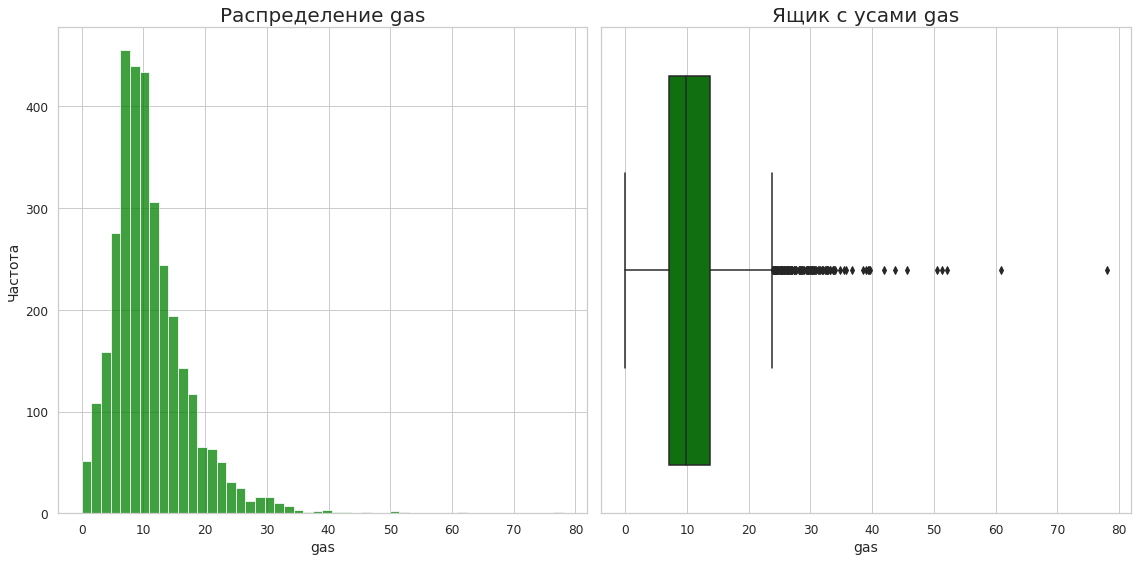

In [35]:
hist_box(data_gas,'gas')

### Анализ data_temp_new

In [36]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [37]:
data_temp.columns = ['key', 'time', 'temperature']
data_temp.columns

Index(['key', 'time', 'temperature'], dtype='object')

Статистическое описание столбца:
count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64


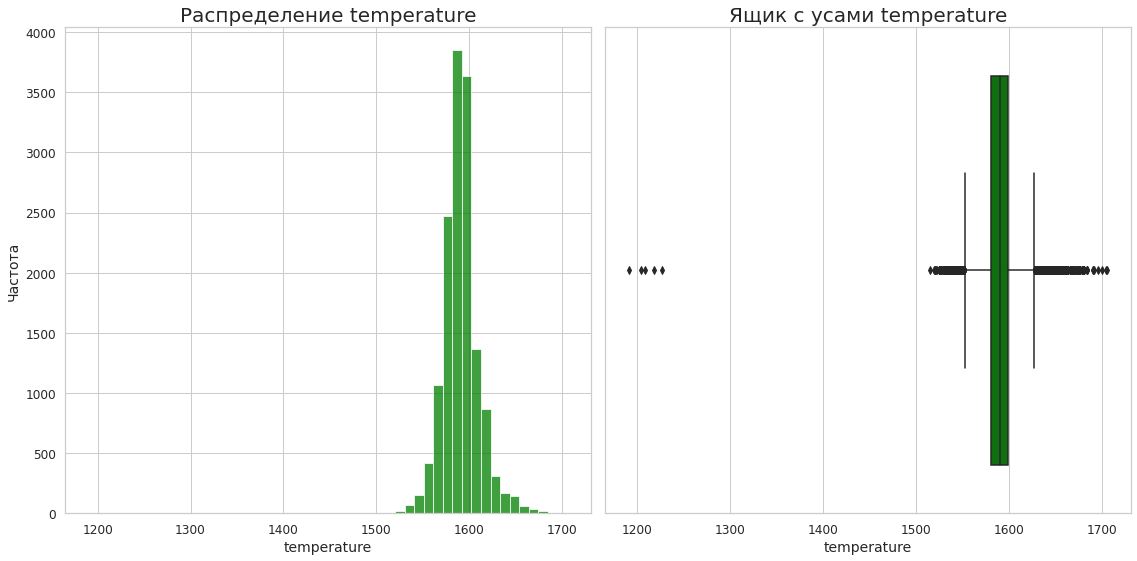

In [38]:
hist_box(data_temp, 'temperature')

Распределение температуры нормальное, но мы видим аномальные значения ниже 1500 градусов. Удалим их.

In [39]:
data_temp = data_temp.query('temperature > 1500')

Статистическое описание столбца:
count    14660.000000
mean      1590.852729
std         19.143141
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64


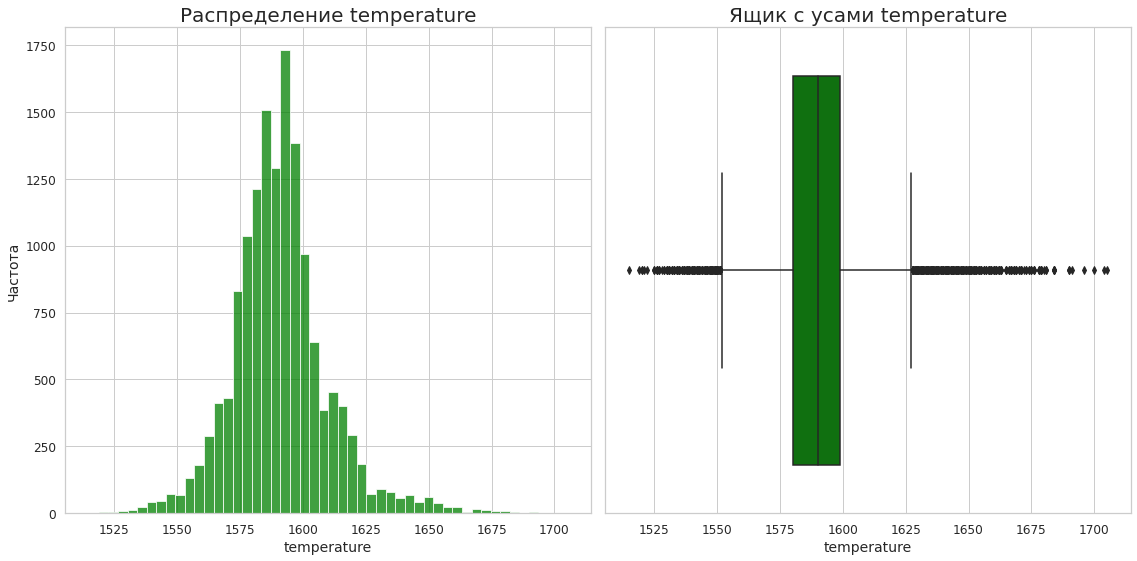

In [40]:
hist_box(data_temp, 'temperature')

In [41]:
data_temp.isna().mean()

key            0.0
time           0.0
temperature    0.0
dtype: float64

In [42]:
data_temp.head()

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [43]:
measurements_rounds = data_temp['key'].value_counts()\
                                      .reset_index(name='measurements_rounds')\
                                      .rename(columns={'index': 'key'})\
                                      .sort_values(by='key', ascending=False)

In [44]:
measurements_rounds.query('measurements_rounds > 1').head()

,key,measurements_rounds
1712,2499,5
968,2498,6
2298,2497,4
602,2496,7
1420,2495,5


С партии 2500 количество измерений равно единице

Добавим признак: разницу между последним и первым замером температуры.

In [45]:
data_temp_final = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()

data_temp_final.columns = ['key', 'first_time', 'finish_time', 'first_temp', 'finish_temp']

data_temp_final['time_diff'] = (data_temp_final['finish_time'] - data_temp_final['first_time']).dt.total_seconds()

data_temp_final = data_temp_final[data_temp_final['key'] < 2500]

data_temp_final.tail()

,key,first_time,finish_time,first_temp,finish_temp,time_diff
2472,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380.0
2473,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705.0
2474,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962.0
2475,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,1520.0
2476,2499,2019-08-10 13:33:21,2019-08-10 13:58:58,1569.0,1603.0,1537.0


### Анализ data_wire_new

In [46]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire = data_wire.rename(columns={f'Wire {i}': f'wire_{i}' for i in range(1, 10)})
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [48]:
pd.DataFrame(round(data_wire.isna().mean()*100,1))

,0
key,0.0
wire_1,0.8
wire_2,65.0
wire_3,98.0
wire_4,99.5
wire_5,100.0
wire_6,97.6
wire_7,99.6
wire_8,99.4
wire_9,99.1


Мы видим что есть много столбцов где пропусков свыше 80%, удалим их

In [49]:
data_wire.drop(['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis= 1 , inplace= True )
data_wire = data_wire.fillna(0)
data_wire.head()

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


Вывод

* Привели названия столбцов к стандартному виду.
* Обработали пропуски и выбросы: удалили столбцы, где процент пропущенных значений превышает 80%. 
* Убрали аномалии по температуре ниже 1500 градусов и отрицательную мощность.
* Добавили дополнительные признаки там, где это показалось уместным.
* Подготовили данные для объединения в общий датасет. Удалили данные с одним измерением температуры.

## Объединение данных

Для объединения таблиц используем все, кроме data_bulk_time_new и data_wire_time_new.

In [50]:
data =  data_arc.merge(data_temp_final, on='key', how='inner')
data = data.merge(data_gas, on='key', how='inner')
data = data.merge(data_bulk, on='key', how='inner')
data = data.merge(data_wire, on='key', how='inner')

In [51]:
info(data)

,key,active_power,reactive_power,real_power,heat_time,electricity_costs,first_time,finish_time,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,3.036730,2.142821,3.718736,1098,770.282114,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0,29.749986,0,43,206,150,154,60.059998,0.00000
1,2,2.139408,1.453357,2.588349,811,481.760005,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0,12.555561,0,73,206,149,154,96.052315,0.00000
2,3,4.063641,2.937457,5.019223,655,722.837668,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0,28.554793,0,34,205,152,153,91.160157,0.00000
3,4,2.706489,2.056992,3.400038,741,683.455597,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0,18.841219,0,81,207,153,154,89.063515,0.00000
4,5,2.252950,1.687991,2.816980,869,512.169934,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0,5.413692,0,78,203,151,152,89.238236,9.11456


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2329 non-null   int64         
 1   active_power       2329 non-null   float64       
 2   reactive_power     2329 non-null   float64       
 3   real_power         2329 non-null   float64       
 4   heat_time          2329 non-null   int64         
 5   electricity_costs  2329 non-null   float64       
 6   first_time         2329 non-null   datetime64[ns]
 7   finish_time        2329 non-null   datetime64[ns]
 8   first_temp         2329 non-null   float64       
 9   finish_temp        2329 non-null   float64       
 10  time_diff          2329 non-null   float64       
 11  gas                2329 non-null   float64       
 12  bulk_3             2329 non-null   int64         
 13  bulk_4             2329 non-null   int64         
 14  bulk_12 

None

Количество дубликатов: 0
Количество пропусков:
key                  0
active_power         0
reactive_power       0
real_power           0
heat_time            0
electricity_costs    0
first_time           0
finish_time          0
first_temp           0
finish_temp          0
time_diff            0
gas                  0
bulk_3               0
bulk_4               0
bulk_12              0
bulk_14              0
bulk_15              0
wire_1               0
wire_2               0
dtype: int64


Удалим признак key а также first_time и finish_time

In [52]:
data.drop(['key', 'first_time', 'finish_time'], axis= 1 , inplace= True )

In [53]:
data.head()

,active_power,reactive_power,real_power,heat_time,electricity_costs,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,3.036730,2.142821,3.718736,1098,770.282114,1571.0,1613.0,1714.0,29.749986,0,43,206,150,154,60.059998,0.00000
1,2.139408,1.453357,2.588349,811,481.760005,1581.0,1602.0,1265.0,12.555561,0,73,206,149,154,96.052315,0.00000
2,4.063641,2.937457,5.019223,655,722.837668,1596.0,1599.0,1753.0,28.554793,0,34,205,152,153,91.160157,0.00000
3,2.706489,2.056992,3.400038,741,683.455597,1601.0,1625.0,1220.0,18.841219,0,81,207,153,154,89.063515,0.00000
4,2.252950,1.687991,2.816980,869,512.169934,1576.0,1602.0,1536.0,5.413692,0,78,203,151,152,89.238236,9.11456


Выводы:

Мы объединили все необходимые датасеты в один итоговый. В нём отсутствуют пропуски и дубликаты, а также удалён признак "key". Итоговый размер датасета составляет (2329, 19).

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [54]:
num_col = ['active_power', 'reactive_power', 'real_power', 'heat_time',
       'electricity_costs', 'first_temp', 'finish_temp', 'time_diff', 'gas',
       'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',
       'wire_2']

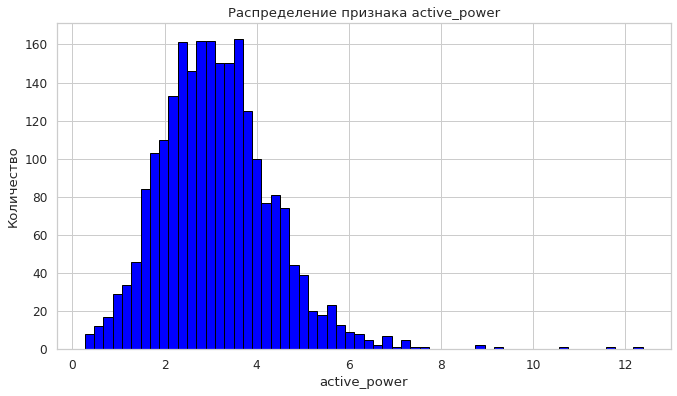

count    2329.000000
mean        3.125033
std         1.221007
min         0.267676
25%         2.293900
50%         3.035365
75%         3.834300
max        12.375636
Name: active_power, dtype: float64


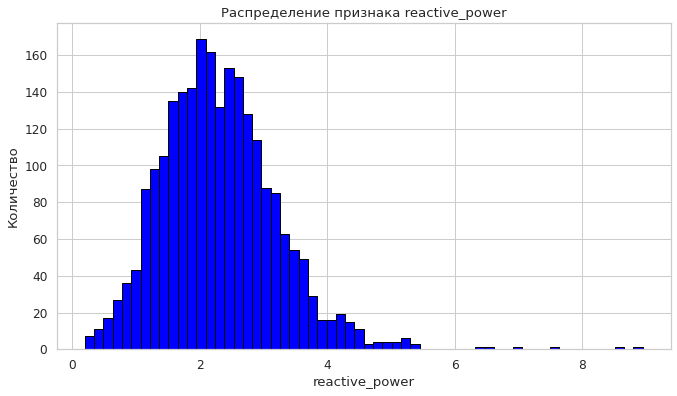

count    2329.000000
mean        2.300522
std         0.903968
min         0.196228
25%         1.669572
50%         2.225398
75%         2.829159
max         8.949049
Name: reactive_power, dtype: float64


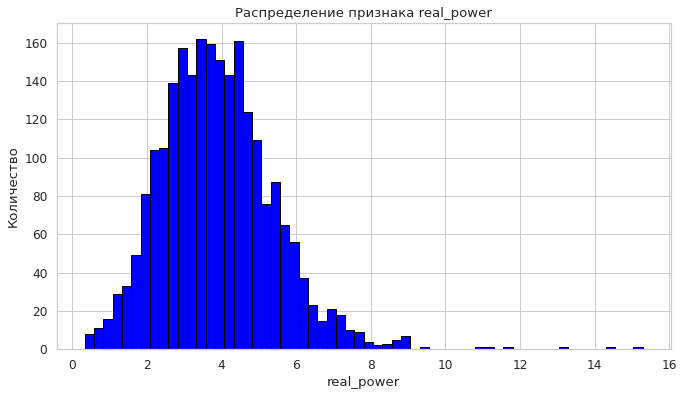

count    2329.000000
mean        3.884654
std         1.518157
min         0.331897
25%         2.843058
50%         3.767499
75%         4.769421
max        15.288271
Name: real_power, dtype: float64


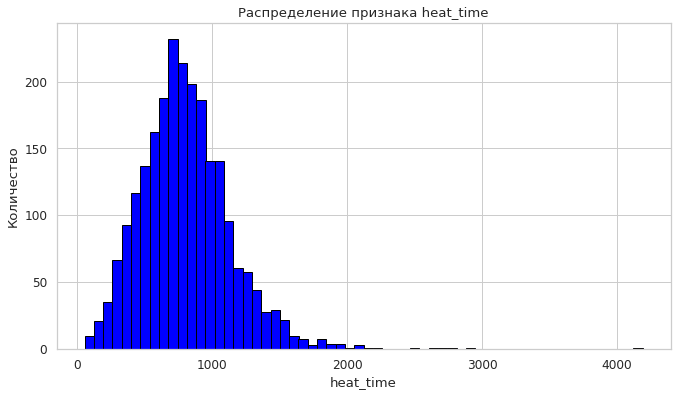

count    2329.000000
mean      807.600687
std       340.897332
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: heat_time, dtype: float64


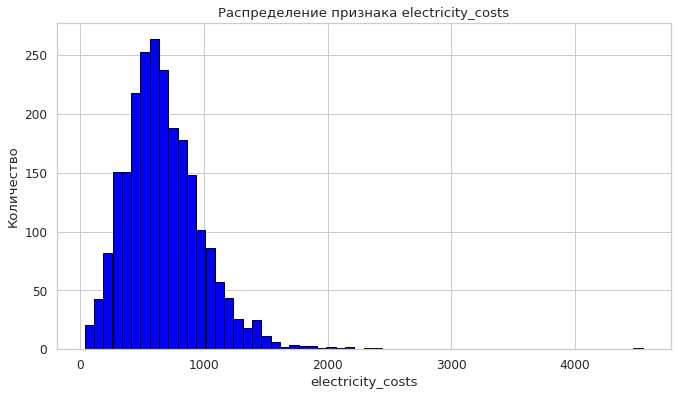

count    2329.000000
mean      669.741514
std       319.531949
min        33.430208
25%       457.864703
50%       630.714148
75%       841.398018
max      4546.405812
Name: electricity_costs, dtype: float64


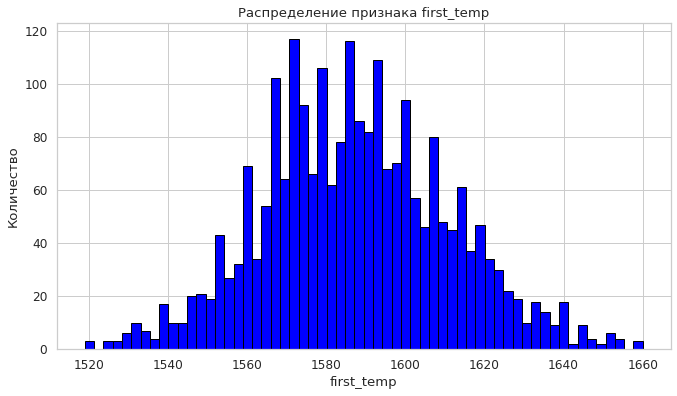

count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: first_temp, dtype: float64


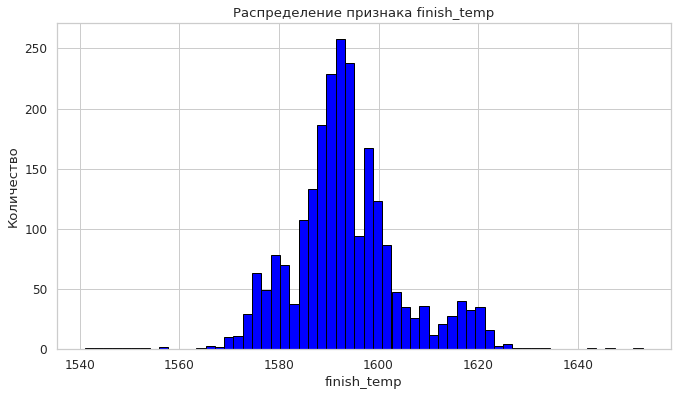

count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: finish_temp, dtype: float64


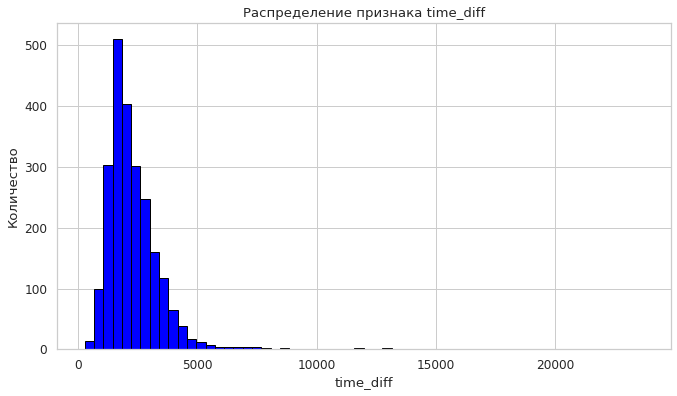

count     2329.000000
mean      2321.810219
std       1385.191527
min        270.000000
25%       1579.000000
50%       2045.000000
75%       2791.000000
max      23674.000000
Name: time_diff, dtype: float64


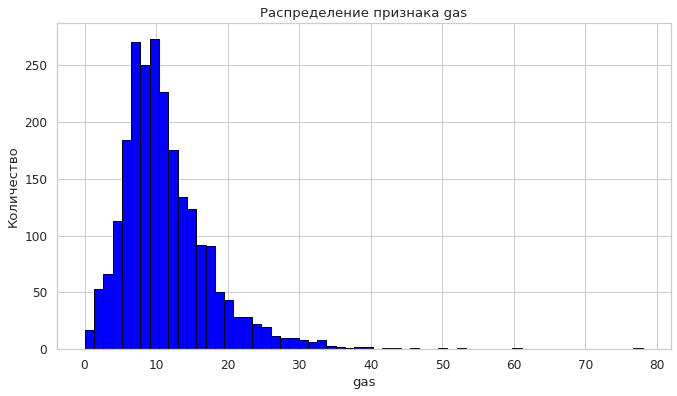

count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: gas, dtype: float64


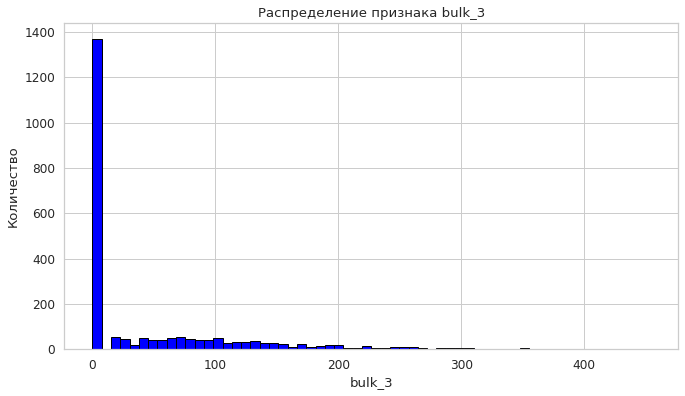

count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


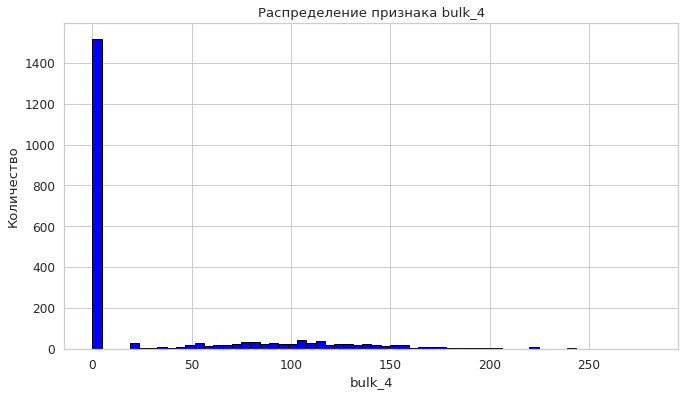

count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64


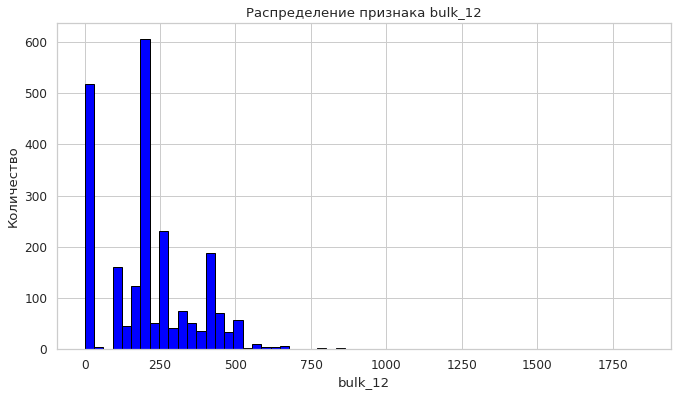

count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: bulk_12, dtype: float64


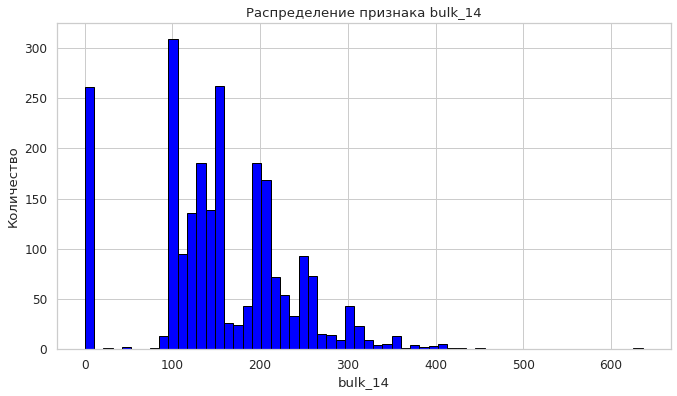

count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64


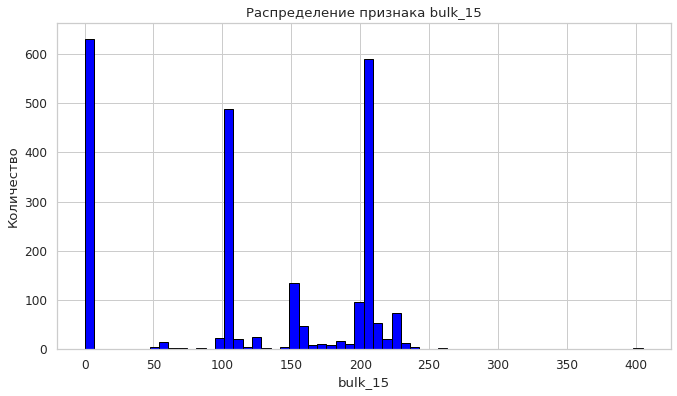

count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


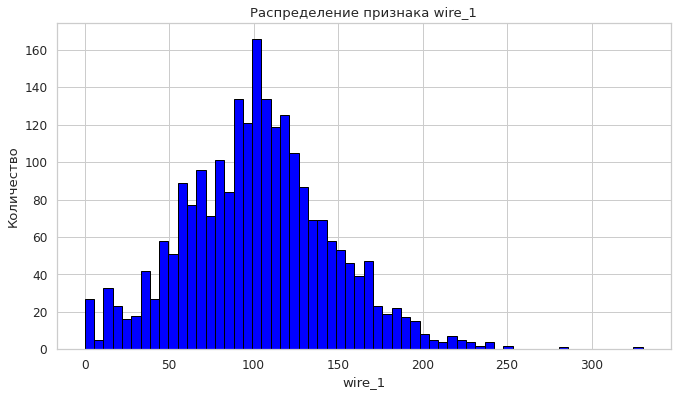

count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: wire_1, dtype: float64


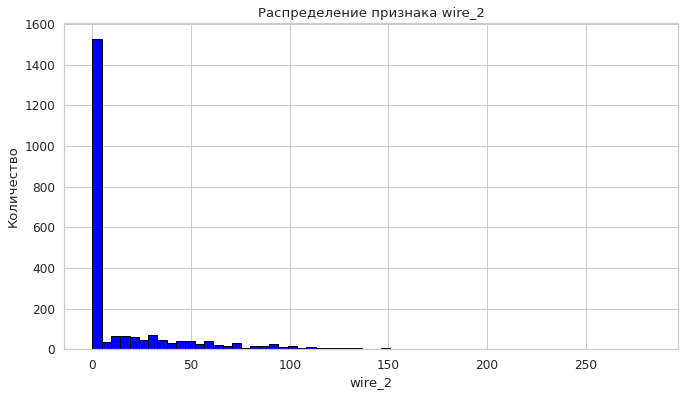

count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64


In [55]:
for col in num_col:
    plt.figure(figsize=(11, 6))
    plt.hist(data[col], color='blue', edgecolor='black', bins=60)
    plt.title(f"Распределение признака {col}")
    plt.ylabel("Количество")
    plt.xlabel(col)
    plt.show()

    print(data[col].describe())

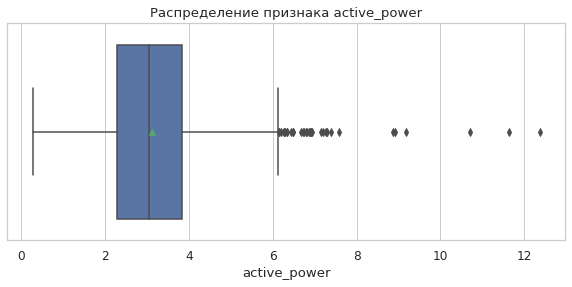

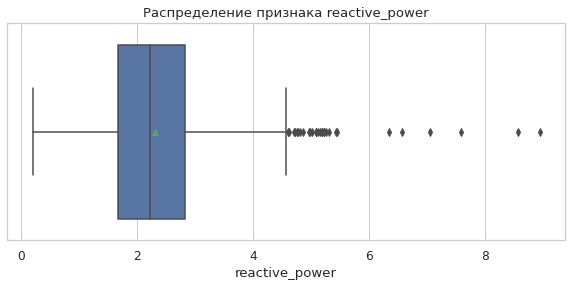

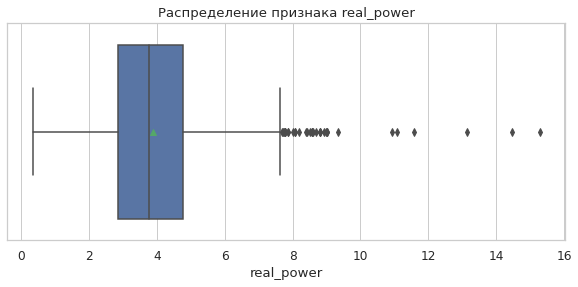

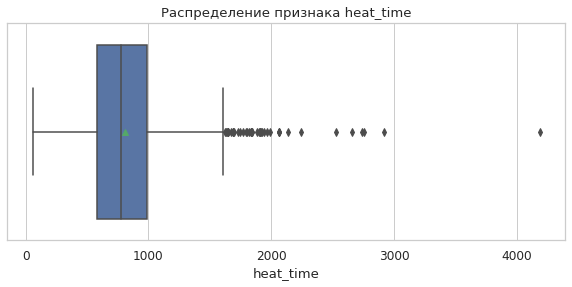

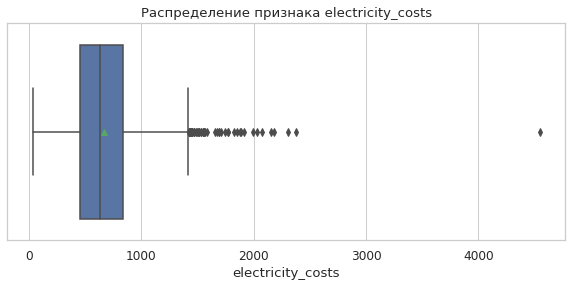

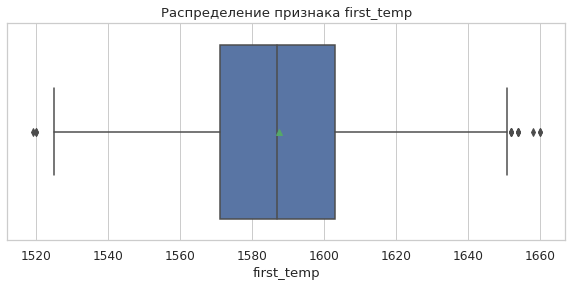

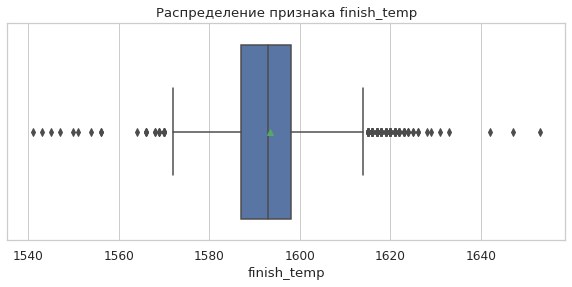

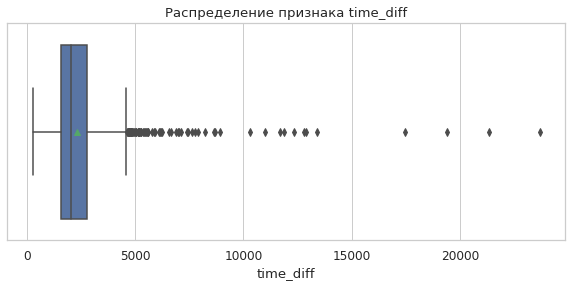

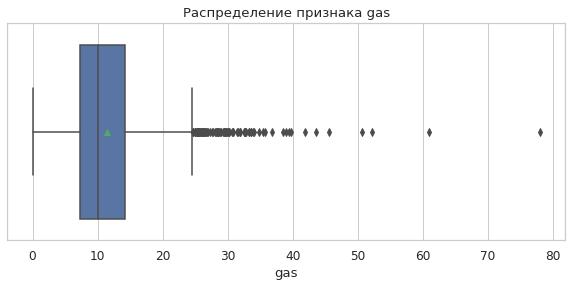

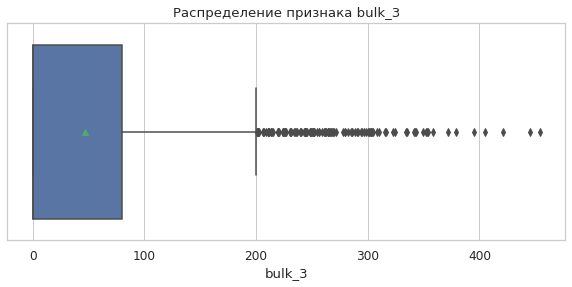

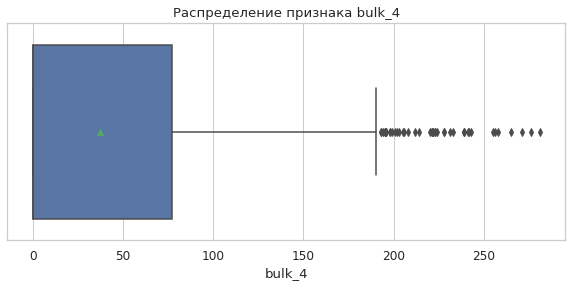

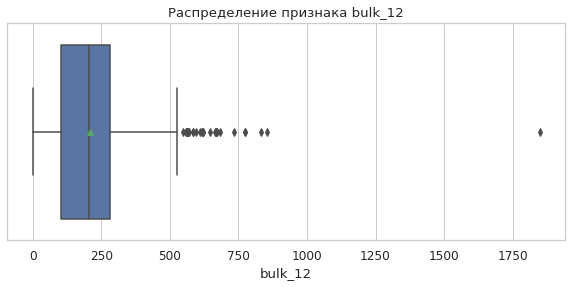

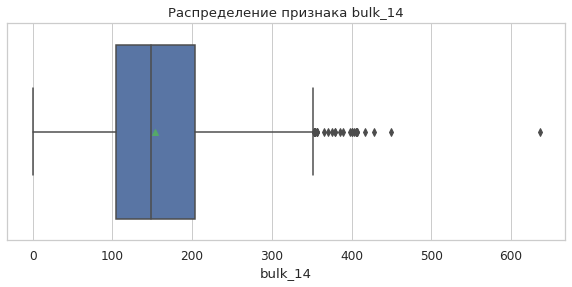

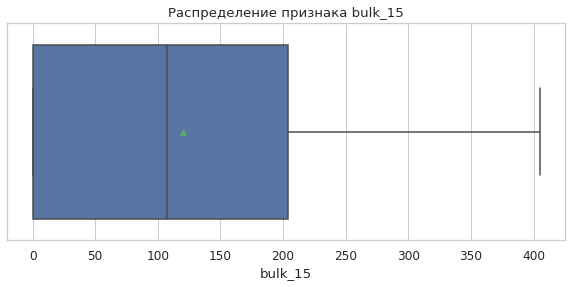

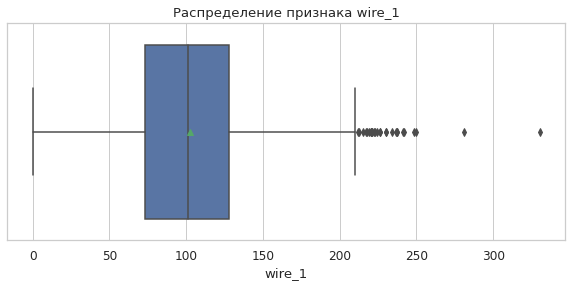

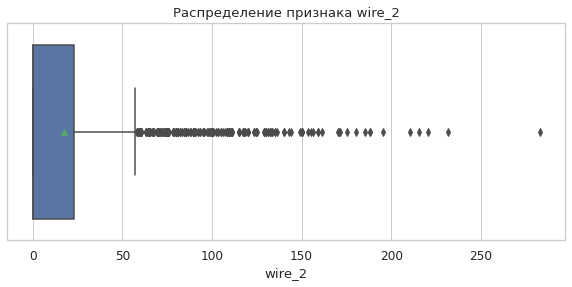

In [56]:
for i in range(len(num_col)):
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[num_col[i]], showmeans=True)
    plt.title(f"Распределение признака {num_col[i]}")
    plt.xlabel(num_col[i])
    plt.show()

После завершения обработки датасета были построены гистограммы и боксплоты для всех признаков. Большинство признаков демонстрируют нормальное распределение, за исключением bulk_3, bulk_4, bulk_15 и wire_2.

Для всех признаков были выявлены выбросы, которые на данном этапе решено оставить без изменений.

Далее будет построена тепловая карта.

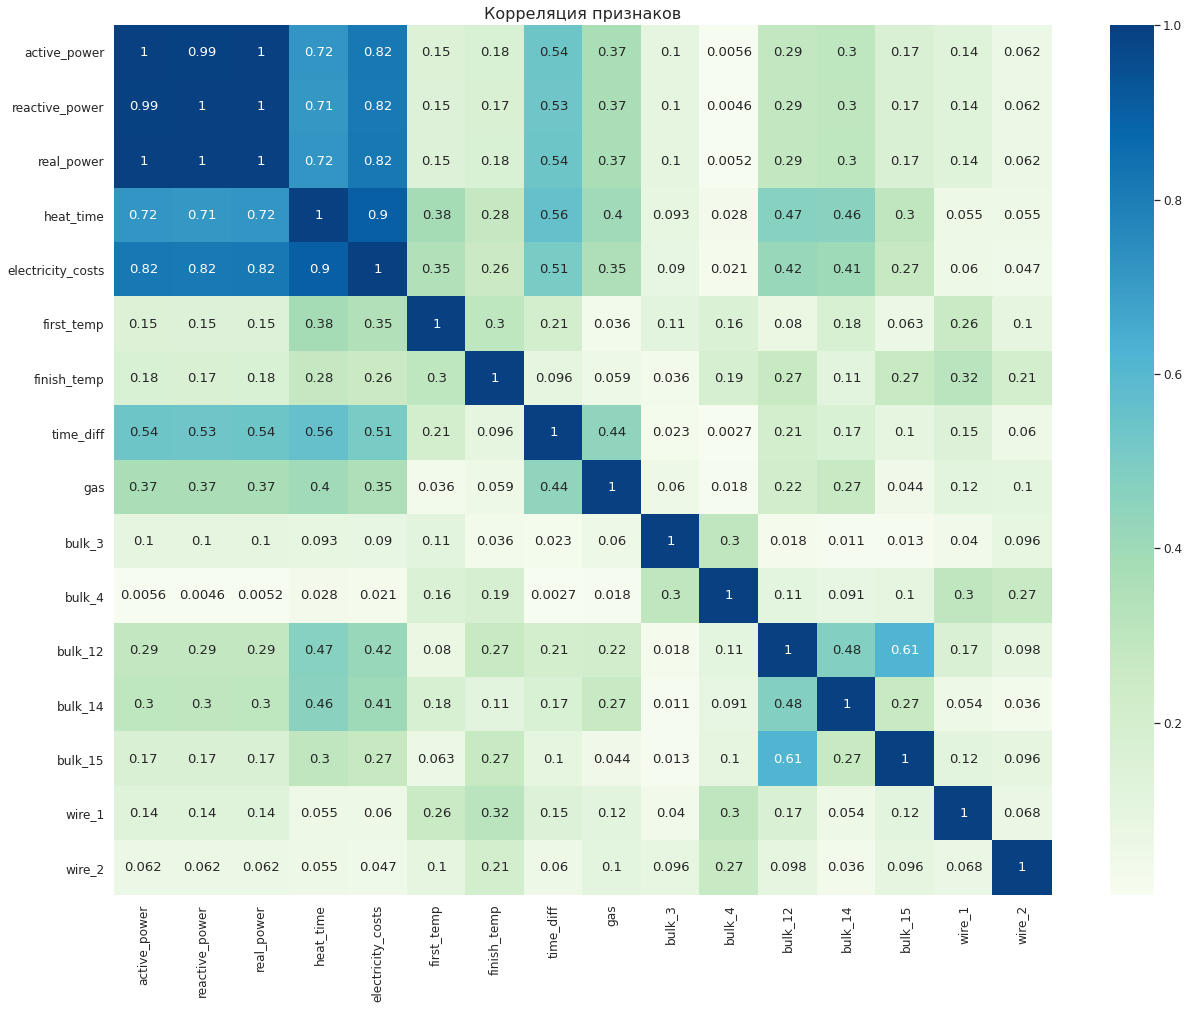

In [57]:
plt.figure(figsize=(21, 16))
fig = sns.heatmap(data.corr().abs(), cmap='GnBu', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=90)
plt.show()

Мы видим что высокая корреляция признаков наблюдается между: 'active_power', 'reactive_power', 'real_power' и 'heating_time'

## Подготовка данных

In [58]:
RANDOM_STATE = 121124
TEST_SIZE = 0.25

In [59]:
X = data.drop('finish_temp', axis=1)
y = data['finish_temp']


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

In [60]:
print('Размер X_train: ', X_train.shape)
print('Размер X_test: ', X_test.shape)
print('Размер y_train: ', y_train.shape)
print('Размер y_test: ', y_test.shape)

Размер X_train:  (1746, 15)
Размер X_test:  (583, 15)
Размер y_train:  (1746,)
Размер y_test:  (583,)


In [62]:
RANDOM_STATE = 121124
TEST_SIZE = 0.25
X = data.drop('finish_temp', axis=1)
y = data['finish_temp']


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()
params = {
    'fit_intercept': [True, False],
}
lin_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
lin_grid.fit(X_train_scaled, y_train)
result_lr = abs(lin_grid.best_score_)
print(f'MAE на тренировочной: {result_lr:.2f}')

# model = LinearRegression()

# params = {
#     'fit_intercept': [True, False],
# }
# lin_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
# lin_grid.fit(X_train_scaled, y_train)
# best_model = lin_grid.best_estimator_
# y_pred = best_model.predict(X_test_scaled)
# mae_test = mean_absolute_error(X_test_scaled, y_pred)
# print(f'MAE (test): {mae_test:.2f}')

MAE на тренировочной: 6.01


Подготовили данные, разделили выборки

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение моделей машинного обучения

### LinearRegression

In [64]:
model = LinearRegression()
params = {
    'fit_intercept': [True, False],
}
lin_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
lin_grid.fit(X_train_scaled, y_train)
result_lr = abs(lin_grid.best_score_)
print(f'MAE на тренировочной: {result_lr:.2f}')

MAE на тренировочной: 6.01


### RandomForestRegressor

In [65]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'random_state': [RANDOM_STATE]
}
rf_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)
result_rf = abs(rf_grid.best_score_)
print(f'MAE на тренировочной: {result_rf:.2f}')

MAE на тренировочной: 6.20


### CatBoostRegressor

In [66]:
%%time

model = CatBoostRegressor(verbose=False)
params = {
    'loss_function': ['MAE'],
    'depth': [4, 6],   # Глубина деревьев, регулирует сложность модели
    'learning_rate': [0.03, 0.1],  # Скорость обучения
    'n_estimators': [100, 500, 1000],    # Количество деревьев
    'random_state': [RANDOM_STATE],  # Фиксация для воспроизводимости
    'l2_leaf_reg': [3, 5, 7],  # Регуляризация для предотвращения переобучения
}
cb_grid = GridSearchCV(model, params, cv=5,verbose=2, scoring='neg_mean_absolute_error')
cb_grid.fit(X_train, y_train)
result_cb = abs(cb_grid.best_score_)
print(f'MAE на тренировочной: {result_cb:.2f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=100, random_state=121124; total time=   1.1s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=100, random_state=121124; total time=   0.9s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=100, random_state=121124; total time=   0.7s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=100, random_state=121124; total time=   0.7s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=100, random_state=121124; total time=   0.7s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=500, random_state=121124; total time=   2.4s
[CV] END depth=4, l2_leaf_reg=3, learning_rate=0.03, loss_function=MAE, n_estimators=500, random_state=121124; total time=   2.3s
[CV] END depth=4, l2_leaf_re

In [67]:
print('Лучшие параметры: ', cb_grid.best_params_)

Лучшие параметры:  {'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.03, 'loss_function': 'MAE', 'n_estimators': 1000, 'random_state': 121124}


### LGBMRegressor

In [68]:
%%time

model = LGBMRegressor()
params = {
    'metric': ['mae'],  
    'max_depth': [3, 5],  # Глубина дерева (гибкость модели)
    'learning_rate': [0.05, 0.1],  # Скорость обучения
    'n_estimators': [100, 200, 500],  # Количество деревьев
    'random_state': [RANDOM_STATE],  # Фиксируем для воспроизводимости
}
lgbm_grid = GridSearchCV(model, params, cv=5, verbose=2, scoring='neg_mean_absolute_error')
lgbm_grid.fit(X_train, y_train)
result_lgbm = abs(lgbm_grid.best_score_)
print(f'MAE на тренировочной: {result_lgbm:.2f}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=100, random_state=121124; total time=   8.6s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=100, random_state=121124; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=100, random_state=121124; total time=  46.3s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=100, random_state=121124; total time=   2.9s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=100, random_state=121124; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=200, random_state=121124; total time=   9.5s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=200, random_state=121124; total time=   7.4s
[CV] END learning_rate=0.05, max_depth=3, metric=mae, n_estimators=200, random_state=121124; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=3, m

In [69]:
print('Лучшие параметры: ', lgbm_grid.best_params_)

Лучшие параметры:  {'learning_rate': 0.05, 'max_depth': 5, 'metric': 'mae', 'n_estimators': 200, 'random_state': 121124}


Выводы

Мы провели обучение моделей LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, использую следующие соотношения разбивки на выборки: 75 к 25.

На тренировочной выборке модели дали следующие результаты:
* LinearRegression: MAE на тренировочной: 6.01
* RandomForestRegressor: MAE на тренировочной: 6.20
* CatBoostRegressor: MAE на тренировочной: 6.02, где лучшие параметры: {'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.03, 'loss_function': 'MAE', 'n_estimators': 1000, 'random_state': 121124}
* LGBMRegressor: MAE на тренировочной: 6.06, где лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'metric': 'mae', 'n_estimators': 200, 'random_state': 121124}.

## Выбор лучшей модели

In [71]:
data = {'MAE на тренировочной':[result_lr, result_rf, result_cb, result_lgbm]}
index = ['LinearRegression','RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
data_final = pd.DataFrame(data=data, index=index)
pd.set_option('precision', 2)
display(data_final.sort_values(by='MAE на тренировочной', ascending=True))#.style.background_gradient(cmap='Blues', axis=0))

,MAE на тренировочной
LinearRegression,6.01
CatBoostRegressor,6.02
LGBMRegressor,6.06
RandomForestRegressor,6.20


Лучшая модель на тренировочной выборке CatBoostRegressor и LinearRegression. Проверим их обоиз на тестовой выборке:

In [72]:
model = LinearRegression()

params = {
    'fit_intercept': [True, False],
}
lin_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
lin_grid.fit(X_train_scaled, y_train)
best_model = lin_grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred)
print(f'MAE (test): {mae_test:.2f}')

MAE (test): 6.32


Модель LinearRegression показала нименьший MAE на тестовой: 6.32

In [75]:
r2 = r2_score(y_test, y_pred)

print(f'r2 на тестовой выборке: {r2:.2f}')

r2 на тестовой выборке: 0.51


Видим, что r2 на тестовой выборке: 0.48 в среднем диапазоне, что говорит о среднем качестве модели.

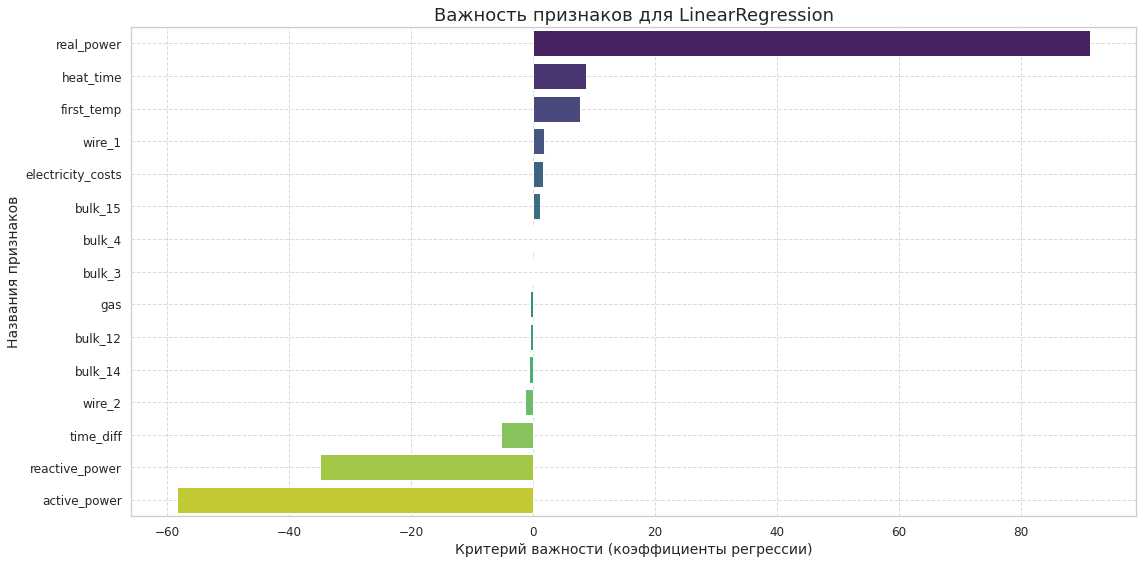

In [74]:
feature_importance_data = {
    'features': X_test.columns,
    'feature_importances': best_model.coef_,
}
feature_importance_data = pd.DataFrame(feature_importance_data)

feature_importance_data.sort_values(by='feature_importances', ascending=False, inplace=True)

plt.figure(figsize=(18, 9))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance_data['feature_importances'], y=feature_importance_data['features'], palette="viridis")

plt.title('Важность признаков для LinearRegression', fontsize=18)
plt.xlabel('Критерий важности (коэффициенты регрессии)', fontsize=14)
plt.ylabel('Названия признаков', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Для модели наиболее влиятельными признаками являются:

* Полная мощность
* Активная мощность

In [76]:
dummy_mean = DummyRegressor('median')
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_train)
mae_score = mean_absolute_error(y_train, dummy_prediction)

print(f'MAE констатной модели на тестовой выборке: {mae_score:.2f}')

MAE констатной модели на тестовой выборке: 7.85


CatBoostRegressor показывает лучшие результаты, чем на константной модели

**Вывод**:

В ходе работы были обучены модели:LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor с использованием соотношения разделения данных на выборки 75:25. Для воспроизводимости результатов задан параметр RANDOM_STATE = 121124.

Размер выборок:

Размер X_train: (1746, 15)
Размер X_test: (583, 15)
Размер y_train: (1746,)
Размер y_test: (583,)

Результаты на тренировочной выборке:

1. RandomForestRegressor: MAE = 6.20
2. CatBoostRegressor: MAE = 6.02
* Лучшие гиперпараметры:
 * depth: 4
 * learning_rate: 0.03
 * loss_function: 'MAE'
 * n_estimators: 1000
 * random_state: 121124
 * l2_leaf_reg: 7
3. LGBMRegressor: MAE = 6.06
* Лучшие гиперпараметры:
 * learning_rate: 0.05
 * max_depth: 5
 * metric: 'mae'
 * n_estimators: 200
 * random_state: 121124
4. LinearRegression: MAE = 6.01

Лучшая модель:

На тренировочной выборке наилучший результат показала модель LinearRegression.

Результаты на тестовой выборке:

* MAE модели LinearRegression = 6.32, что удовлетворяет поставленному условию (MAE ≤ 6.8).
* Значение R² на тестовой выборке: 0.48, что указывает на среднее качество модели.

Анализ важности признаков:
Наиболее значимые признаки для модели:
* Полная мощность
* Активная мощность

MAE констатной модели на тестовой выборке: 7.85. LinearRegression показывает лучшие результаты чем на константной модели

## ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

Цель проекта — оптимизация производственных расходов металлургического комбината посредством разработки модели машинного обучения для прогнозирования температуры сплава.

**Основные аспекты:**
* **Целевая переменная (target):** последняя температура партии.

* **Целевая метрика:** MAE (целевое значение ≤ 6.8 на тестовой выборке).

* **Исходные данные:** предоставлены в нескольких файлах, каждый из которых отражает определенные производственные аспекты:
 * data_arc_new.csv — информация об электродах.
 * data_bulk_new.csv и data_bulk_time_new.csv — данные о сыпучих материалах.
 * data_gas_new.csv — данные о продувке газом.
 * data_temp_new.csv — результаты измерения температуры.
 * data_wire_new.csv и data_wire_time_new.csv — информация о проволочных материалах.

**Обработка данных:**

data_arc_new.csv (электроды):

* Переименованы столбцы по PEP8.
* Удалены партии с отрицательной реактивной мощностью.
* Добавлены расчеты полной мощности, времени нагрева (в секундах) и энергозатрат.

data_bulk_new.csv (сыпучие материалы):

* Переименованы столбцы по PEP8.
* Удалены признаки с более чем 80% пропущенных значений, оставшиеся пропуски заменены на нули.

data_gas_new.csv (продувка газом):

* Переименованы столбцы по PEP8.

data_temp_new.csv (температура):

* Переименованы столбцы по PEP8.
* Удалены партии с температурой < 1500°C, а также данные с единственным замером температуры или с пропущенными значениями.
* Определены начальная и конечная температуры.

data_wire_new.csv (проволочные материалы):

* Переименованы столбцы по PEP8.
* Удалены признаки с более чем 80% пропущенных значений, оставшиеся пропуски заменены на нули.

Итоговое объединение данных:

* Исключены файлы data_bulk_time_new и data_wire_time_new.
* Удален столбец key. Итоговый датасет: 2329 строк, 19 признаков.

**Анализ данных:** 

* Проведены гистограммы и боксплоты: большинство признаков имеют нормальное распределение, кроме bulk_3, bulk_4, bulk_15, wire_2.
* Построена тепловая карта: высокая корреляция между active_power, reactive_power, real_power и heating_time.

**Построение модели:**

* Используемые модели:LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor.
* Разделение данных:
 * Обучающая выборка: 75% (1746 строк).
 * Тестовая выборка: 25% (583 строки).

**Результаты моделей (MAE на обучающей выборке):**

* LinearRegression: 6.02
* RandomForestRegressor: 6.20
* CatBoostRegressor: 6.03
* LGBMRegressor: 6.06

**Результаты на тестовой выборке:**

* Лучшая модель — LinearRegression: MAE = 6.32 (целевая метрика выполнена).
* Коэффициент детерминации R² = 0.46, что свидетельствует о среднем качестве модели.

**Важность признаков:**
Ключевые:

* Полная мощность
* Активная мощность

**Рекомендации**

* Уделить внимание точности и своевременности замерам температуры
* Исключить или технологически обосновать наличие значимого количества выбросов, что вероятно даст возможность построению более точной модели(если убрать выбросы) с более высоким показателем r2.